In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#Read in data
data = pd.read_csv('Resources/wildfires_ml5.csv')
data.head()

,CAUSE,FIRE_YEAR,LATITUDE,LONGITUDE,STATE,FIRE_SIZE,DURATION,MONTH,DAY_OF_WEEK,OWNER
0,4,2005,40.036944,-121.005833,4,0.10,0.0,2,2,3
1,1,2004,38.933056,-120.404444,4,0.25,0.0,5,2,3
2,2,2004,38.984167,-120.735556,4,0.10,0.0,5,0,5
3,1,2004,38.559167,-119.913333,4,0.10,5.0,6,0,3
4,1,2004,38.559167,-119.933056,4,0.10,5.0,6,0,3


In [4]:
#Set independent variables
X = data.iloc[:,1:10]
X.head()

,FIRE_YEAR,LATITUDE,LONGITUDE,STATE,FIRE_SIZE,DURATION,MONTH,DAY_OF_WEEK,OWNER
0,2005,40.036944,-121.005833,4,0.10,0.0,2,2,3
1,2004,38.933056,-120.404444,4,0.25,0.0,5,2,3
2,2004,38.984167,-120.735556,4,0.10,0.0,5,0,5
3,2004,38.559167,-119.913333,4,0.10,5.0,6,0,3
4,2004,38.559167,-119.933056,4,0.10,5.0,6,0,3


In [5]:
y = data.iloc[:,0]

In [6]:
print(X.shape, y.shape)

(988934, 9) (988934,)


In [7]:
#Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=200)
clf_rf = clf_rf.fit(X_train_scaled, y_train)
print(clf_rf.score(X_test_scaled,y_test))

0.7280349790077416


In [10]:
importance_data = sorted(list(zip(X.columns,clf_rf.feature_importances_)), key=lambda tpl:tpl[1], reverse=True)

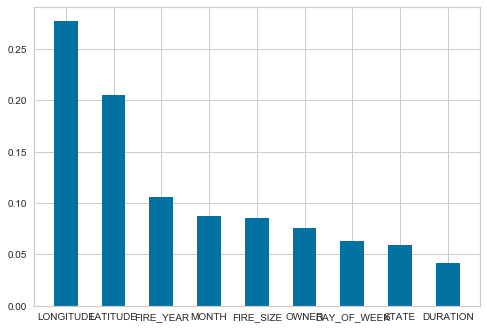

In [58]:
plt.clf()
xs = range(len(importance_data))
labels = [x for (x,_) in importance_data]
ys = [y for (_,y) in importance_data]

plt.bar(xs, ys, width=0.5, color="orange")
plt.xticks(xs, labels, rotate=90)
plt.show()

In [13]:
importance_data

[('LONGITUDE', 0.2772337135646719),
 ('LATITUDE', 0.20532060243518638),
 ('FIRE_YEAR', 0.10584551165716666),
 ('MONTH', 0.08706724648996163),
 ('FIRE_SIZE', 0.08508631092888846),
 ('OWNER', 0.07576374551924617),
 ('DAY_OF_WEEK', 0.0630338009462969),
 ('STATE', 0.05920417362980727),
 ('DURATION', 0.04144489482877474)]

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = clf_rf.predict(X_test_scaled)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[48792  5362   509  2154]
 [ 6312 73291  6690  8643]
 [  988 12196 19730  3586]
 [ 3370 15048  2381 38182]]
              precision    recall  f1-score   support

           1       0.82      0.86      0.84     56817
           2       0.69      0.77      0.73     94936
           3       0.67      0.54      0.60     36500
           4       0.73      0.65      0.68     58981

    accuracy                           0.73    247234
   macro avg       0.73      0.70      0.71    247234
weighted avg       0.73      0.73      0.72    247234



In [18]:
import itertools

In [19]:
matrix = confusion_matrix(y_test, predictions)

In [20]:
class_names = ['Nature','Accident','Intentional','Misc/Unknown']

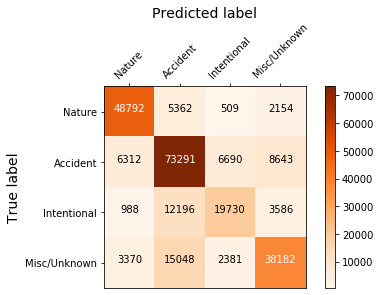

In [22]:
plt.clf()

# place labels at the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# plot the matrix per se
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Oranges)

# plot colorbar to the right
plt.colorbar()
    
fmt = 'd'

# write the number of predictions in each bucket
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):

    # if background is dark, use a white number, and vice-versa
    plt.text(j, i, format(matrix[i, j], fmt),
         horizontalalignment="center",
         color="white" if matrix[i, j] > thresh else "black")
    
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label',size=14)
plt.xlabel('Predicted label',size=14)
plt.show()

In [29]:
y_score = clf_rf.predict_proba(X_test_scaled)

In [31]:
#Binarize the output
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

In [36]:
from sklearn import metrics
from sklearn.metrics import roc_curve

AUC for Class 1: 0.9673873618342111
AUC for Class 2: 0.864572627877973
AUC for Class 3: 0.8961978773214196
AUC for Class 4: 0.8914098727823491


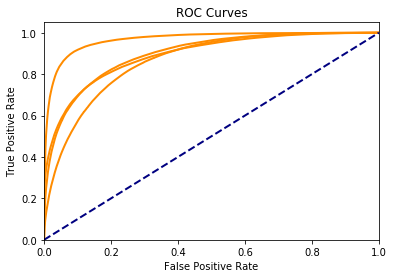

In [38]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
  print('AUC for Class {}: {}'.format(i+1, metrics.auc(fpr[i], tpr[i])))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

In [45]:
from sklearn import tree
tr = tree.DecisionTreeClassifier()
tr = tr.fit(X_train_scaled, y_train)
tr.score(X_test_scaled,y_test)

0.6391717967593454

In [46]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train_scaled, y_train)
gnb.score(X_test_scaled,y_test)

0.4602562754313727

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbc = gbc.fit(X_train_scaled, y_train)
gbc.score(X_test_scaled, y_test)

0.6267625003033563